<a href="https://colab.research.google.com/github/EzequielAssis/Landsat8-satellite-scenes/blob/main/landsat8_scenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalações necessárias

In [ ]:
!pip install geopandas
!pip install rtree
!pip install pygeos
!git clone https://github.com/EzequielAssis/Shapefiles.git

##Importação de bibliotecas

In [13]:
import requests
import json
import pandas as pd
import numpy as np
import copy
import tarfile
import matplotlib.pyplot as plt
import geopandas as gpd
import os

##Leitura do shapefile

In [14]:
##PERNAMBUCO (remove-se Fernando de Noronha do shapefile)
#br_shp = gpd.read_file('/content/Shapefiles/PE-MUN/26MUE250GC_SIR.shp')
##Removendo Fernando de Noronha para melhor visualização do estado
#rm_fn = br_shp.loc[br_shp['NM_MUNICIP'] == 'FERNANDO DE NORONHA'].index.values
#shp = br_shp.drop(labels=rm_fn)

In [15]:
##Qualquer estado do Brasil
#br_shp = gpd.read_file('/content/Shapefiles/Brasil/UFEBRASIL.shp')
#br_shp['ID'] = [x for x in range(br_shp.shape[0])]
#print('ESCOLHA DO ESTADO POR MEIO DO INDEX\n\n')
#display(br_shp[['ID', 'NM_ESTADO']])
#index = 16
#shp = br_shp.loc[[index]]

In [16]:
##BRASIL
#as_shp = gpd.read_file('/content/Shapefiles/shapefile_país/pais.shp')
#shp = as_shp.loc[as_shp['NOME'] == 'BRASIL']
#shp

In [17]:
#Regiões do Brasil
re_shp = gpd.read_file('/content/Shapefiles/regioes_do_Brasil/regioes_2010.shp')
shp = re_shp.loc[re_shp['nome'] == 'Nordeste']
shp

,id,nome,sigla,geometry
3,4,Nordeste,NE,"MULTIPOLYGON (((-35.15204 -8.91295, -35.15366 ..."


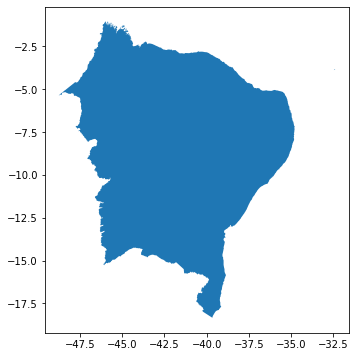

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)

In [19]:
#A máxima e mínima de latitude e longitude
xmin, ymin, xmax, ymax = shp.total_bounds

xmin = xmin-0.05

#Ajustado em -2 para corrigir a longitude do lado direito
#Usar +0.05 na leitura de outros  shapefiles
xmax = xmax-2

ymin = ymin-0.05
ymax = ymax+0.05

size = 200

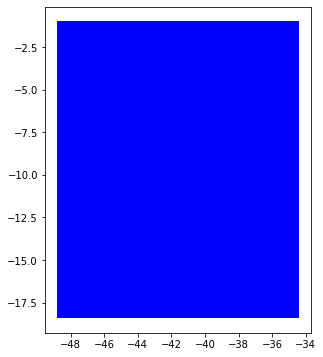

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
#Cria um shapefile retangular a paritr dos limites do shp acima
from shapely.geometry import Polygon

lat_point = [ymin, ymin, ymax, ymax]
lon_point = [xmin, xmax, xmax, xmin]

polygon_geom = Polygon(zip(lon_point, lat_point))

crs = shp.crs #
polygon_retang = gpd.GeoDataFrame(geometry=[polygon_geom], crs=crs)

polygon_retang.plot(figsize=(6,6), color='blue')
plt.show()
display(crs)

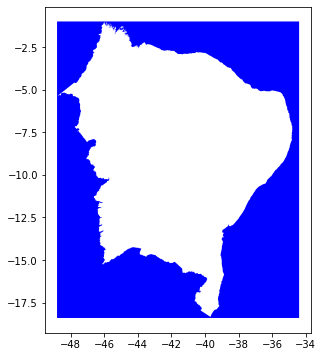

In [21]:
#"Recorta" o shapefile lido dentro do shapefile retangular criado
shp_cut = polygon_retang.overlay(shp, how="difference")
shp_cut.plot(figsize=(6,6), color='blue', alpha=1)
plt.show()

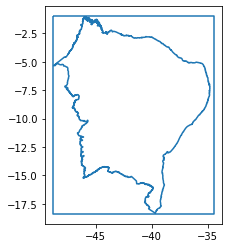

In [22]:
#Cria umm shapefile de linhas
shp_bound = shp_cut.boundary
shp_bound.plot()

In [23]:
display(xmin, ymin, xmax, ymax)

-48.80471282282593

-18.398743440010595

-34.39087522629802

-0.9950854229755668

#Requisição de cenas do satélite Landsat 8
* Manual API EROS USGS: https://m2m.cr.usgs.gov/
* Manual API ESPA USGS: https://espa.cr.usgs.gov/
* Bulk Download: https://code.usgs.gov/espa/bulk-downloader

#**<font color='red'>API EROS para buscar nome das cenas para uma região específica</font>**

In [24]:
# send http request
def sendRequest(url, data, apiKey = None):
    json_data = json.dumps(data)
    if apiKey == None:
        response = requests.post(url, json_data)
    else:
        headers = {'X-Auth-Token': apiKey}              
        response = requests.post(url, json_data, headers = headers)   
        #display(response.json())
    try:
      httpStatusCode = response.status_code 
      if response == None:
          print("No output from service")
          sys.exit()
    
      output = json.loads(response.text)

      if output['errorCode'] != None:
          print(output['errorCode'], "- ", output['errorMessage'])
          sys.exit()
    
      if  httpStatusCode == 404:
          print("404 Not Found")
          sys.exit()
    
      elif httpStatusCode == 401: 
          print("401 Unauthorized")
          sys.exit()
    
      elif httpStatusCode == 400:
          print("Error Code", httpStatusCode)
          sys.exit()
    
    except Exception as e: 
          response.close()
          print(e)
          sys.exit()
    response.close()
    response = response.json()
    return output['data']

In [ ]:
# user input
username = 'USERNAME'
password = 'PASSWORD'

serviceUrl = "https://m2m.cr.usgs.gov/api/api/json/stable/"

# login
payload = {'username' : username, 'password' : password}

apiKey = sendRequest(serviceUrl + "login", payload)

print("API Key: " + apiKey + "\n")

In [27]:
def cloud_cover(scenes):
    data_scene = {}

    for scene in scenes['results']:
        sc_name = scene['displayId']
        pathRow = sc_name[10:16]

        if pathRow in data_scene.keys():
            if sc_name[-2:] != 'T1' and data_scene[pathRow][0][-2:] == 'T1':
                continue

            elif sc_name[-2:] == 'T1' and data_scene[pathRow][0][-2:] != 'T1':
                #print(data_scene[pathRow][0]+" ==> "+sc_name)
                data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]

            elif data_scene[pathRow][1] > float(scene['cloudCover']):
                data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]
        else:
            data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]


    l8_ls = [x[0] for x in list(data_scene.values())]

    cloud = [x[1] for x in list(data_scene.values())]
    cloud_m = np.array(cloud).mean()
    return cloud_m

In [28]:
from datetime import datetime, timedelta

In [29]:
datasetName = "landsat_ot_c2_l2"
#datasetName = "landsat_ot_c2_l1"
#datasetName = 'modis_mod13q1_v61'

spatialFilter =  {'filterType' : "mbr",
                  'lowerLeft' : {'latitude' : ymin, 'longitude' : xmin},
                  'upperRight' : { 'latitude' : ymax, 'longitude' : xmax}}

# find additional filters

list_cloud = []
date_start = datetime(2020, 1, 1)

date_end = date_start + timedelta(days=32)

for i in range(50):

    acquisitionFilter = {"start": f"{date_start}",
                            "end": f"{date_end}"}

    payload = {'datasetName' : datasetName,
                                'maxResults' : 500,
                                'startingNumber' : 1,
                                'sceneFilter' : {
                                                'spatialFilter': spatialFilter,
                                                'acquisitionFilter': acquisitionFilter}}
                                                #"cloudCoverFilter": cloudCoverFilter}}

    # Now I need to run a scene search to find data to download
    #print("Searching scenes...\n\n")

    scenes = sendRequest(serviceUrl + "scene-search", payload, apiKey)

    print(f'found {len(scenes["results"])} scenes!!')
    cloud_porcent = cloud_cover(scenes)
    print(f'start: {date_start} | end: {date_end} | cloud: {cloud_porcent}\n')
    list_cloud.append([cloud_porcent, date_start, date_end])

    #print(json.dumps(scenes, indent=4))

    date_start += timedelta(days=7)
    date_end += timedelta(days=7)

# Did we find anything?
            
# Logout so the API Key cannot be used anymore
#endpoint = "logout"  
#if sendRequest(serviceUrl + endpoint, None, apiKey) == None:        
#    print("Logged Out\n\n")
#else:
#    print("Logout Failed\n\n")

found 236 scenes!!
start: 2020-01-01 00:00:00 | end: 2020-02-02 00:00:00 | cloud: 45.040625

found 236 scenes!!
start: 2020-01-08 00:00:00 | end: 2020-02-09 00:00:00 | cloud: 44.714999999999996

found 236 scenes!!
start: 2020-01-15 00:00:00 | end: 2020-02-16 00:00:00 | cloud: 45.98973214285714

found 237 scenes!!
start: 2020-01-22 00:00:00 | end: 2020-02-23 00:00:00 | cloud: 47.44508928571429

found 237 scenes!!
start: 2020-01-29 00:00:00 | end: 2020-03-01 00:00:00 | cloud: 43.949732142857144

found 232 scenes!!
start: 2020-02-05 00:00:00 | end: 2020-03-08 00:00:00 | cloud: 46.68901785714286

found 227 scenes!!
start: 2020-02-12 00:00:00 | end: 2020-03-15 00:00:00 | cloud: 46.626071428571436

found 224 scenes!!
start: 2020-02-19 00:00:00 | end: 2020-03-22 00:00:00 | cloud: 50.00892857142857

found 224 scenes!!
start: 2020-02-26 00:00:00 | end: 2020-03-29 00:00:00 | cloud: 50.257767857142845

found 224 scenes!!
start: 2020-03-04 00:00:00 | end: 2020-04-05 00:00:00 | cloud: 48.7856249999

In [30]:
#Ordena a lista a partir da coluna de nuvem %
def takeSecond(elem):
    return elem[0]

min_cl_cv = sorted(list_cloud, key=takeSecond)[0]
min_cl_cv #Range de data de cobertura de nuvem mínima

[9.722142857142858,
 datetime.datetime(2020, 9, 9, 0, 0),
 datetime.datetime(2020, 10, 11, 0, 0)]

In [31]:
datasetName = "landsat_ot_c2_l2"
#datasetName = "landsat_ot_c2_l1"
#datasetName = 'modis_mod13q1_v61'

spatialFilter =  {'filterType' : "mbr",
                  'lowerLeft' : {'latitude' : ymin, 'longitude' : xmin},
                  'upperRight' : { 'latitude' : ymax, 'longitude' : xmax}}
                  #'lowerRight' : {'latitude' : ymin, 'longitude' : xmax},
                  #'upperLeft' : { 'latitude' : ymax, 'longitude' : xmin}}

# find additional filters

date_start = min_cl_cv[1].strftime("%Y-%m-%d")
date_end = min_cl_cv[2].strftime("%Y-%m-%d")

acquisitionFilter = {"start": f"{date_start}",
                        "end": f"{date_end}"}

#cloudCoverFilter = {"max": 15,
#                    "min": 0,
#                    "includeUnknown": True}

payload = {'datasetName' : datasetName,
                            'maxResults' : 500,
                            'startingNumber' : 1,
                            'sceneFilter' : {
                                            'spatialFilter': spatialFilter,
                                            'acquisitionFilter': acquisitionFilter}}
                                            #"cloudCoverFilter": cloudCoverFilter}}

# Now I need to run a scene search to find data to download
print("Searching scenes...\n\n")
scenes = sendRequest(serviceUrl + "scene-search", payload, apiKey)
print(f'found {len(scenes["results"])} scenes!!\n')
#print(json.dumps(scenes, indent=4))

Searching scenes...


found 237 scenes!!



In [32]:
data_scene = {}

for scene in scenes['results']:
    sc_name = scene['displayId']
    pathRow = sc_name[10:16]

    if pathRow in data_scene.keys():
        if sc_name[-2:] != 'T1' and data_scene[pathRow][0][-2:] == 'T1':
            continue

        elif sc_name[-2:] == 'T1' and data_scene[pathRow][0][-2:] != 'T1':
            #print(data_scene[pathRow][0]+" ==> "+sc_name)
            data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]

        elif data_scene[pathRow][1] > float(scene['cloudCover']):
            print(f'{data_scene[pathRow][1]} ', end=' ==> ')
            data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]
            print(f'{data_scene[pathRow][1]}', end='\n\n')
    else:
        data_scene[pathRow] = [sc_name, float(scene['cloudCover'])]


l8_ls = [x[0] for x in list(data_scene.values())]

#display(l8_ls)
cloud = [x[1] for x in list(data_scene.values())]
cloud_m = np.array(cloud).mean()
print(f'{len(l8_ls)} cenas adquiridas')
print(f'\nMédia de cobertura de nuvem em toda região: {cloud_m:.2f} %')

50.37  ==> 38.99

63.46  ==> 58.76

99.95  ==> 96.28

91.09  ==> 82.94

64.97  ==> 57.58

88.24  ==> 44.61

93.47  ==> 14.23

95.27  ==> 1.33

99.98  ==> 0.4

94.52  ==> 0.01

23.24  ==> 15.36

57.92  ==> 18.26

76.64  ==> 43.36

27.19  ==> 23.16

12.69  ==> 4.1

44.71  ==> 34.18

43.06  ==> 19.97

51.6  ==> 23.89

88.39  ==> 15.31

67.42  ==> 17.49

23.31  ==> 12.88

21.11  ==> 11.5

30.06  ==> 6.63

54.36  ==> 6.53

33.43  ==> 0.01

18.48  ==> 0.0

0.79  ==> 0.0

69.86  ==> 11.35

29.56  ==> 15.92

91.19  ==> 58.43

31.11  ==> 9.75

47.56  ==> 14.8

14.61  ==> 1.71

2.28  ==> 0.0

18.14  ==> 3.5

11.84  ==> 1.98

10.39  ==> 0.0

8.37  ==> 0.0

0.13  ==> 0.01

38.99  ==> 18.88

58.76  ==> 22.4

87.93  ==> 32.19

96.28  ==> 4.26

98.86  ==> 0.32

82.94  ==> 0.02

57.58  ==> 0.0

44.61  ==> 0.01

14.23  ==> 0.0

1.33  ==> 0.0

0.4  ==> 0.0

0.01  ==> 0.0

112 cenas adquiridas

Média de cobertura de nuvem em toda região: 9.72 %


#API ESPA - Login

##Função principal

In [33]:
import platform
print(platform.python_version())


# The current URL hosting the ESPA interfaces has reached a stable version 1.0


host = 'https://espa.cr.usgs.gov/api/v1/'

# ESPA uses the ERS credentials for identifying users

username = 'USERNAME'
password = 'PASSWORD'

def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    #print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print((json.dumps(messages, indent=4)))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

3.7.13


##Login

In [ ]:
print('GET /api/v1/user')
resp = espa_api('user')
print((json.dumps(resp, indent=4)))
email = resp['email']

# **<font color='red'>Requisição das cenas</font>**
- obs: para não repetir requisições, pule para a próxima célula para verificar se há requisições para download.

In [ ]:
#print('GET /api/v1/projections')
#projs = espa_api('projections')
#print(json.dumps(list(projs.keys())))
#
#
## This is a Schema Definition, useful for building a valid order
## 
## Example (*lonlat Projection*):
#
## In[12]:
#print('lonlat projection')
#print(json.dumps(projs, indent=4))

In [52]:
l8_prods = ['sr_ndvi']

#l8_ls = ['MYD13A1.A2012265.h17v08.006.2015249154919']
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print((json.dumps(order, indent=4)))


order['olitirs8_collection_2_l2']['products'] = l8_prods

# Add in the rest of the order information
order['projection'] = {'lonlat': None} #projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = f'Cenas do Nordeste do Brasil entre {date_start} e {date_end}'

# Notice how it has changed from the original call available-products
print((json.dumps(order, indent=4)))

# Place the order
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print((json.dumps(resp, indent=4)))

# Here we cancel an incomplete order

#cancel_request = {"orderid": orderid, "status": "cancelled"}
#print('PUT /api/v1/order')
#order_status = espa_api('order', verb='put', body=cancel_request)
#
#print((json.dumps(order_status, indent=4)))

GET /api/v1/available-products
{
    "olitirs8_collection_2_l2": {
        "products": [
            "l1",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "sr_ndsi"
        ],
        "inputs": [
            "LC08_L2SP_222060_20201011_20201016_02_T2",
            "LC08_L2SP_222061_20200909_20200919_02_T1",
            "LC08_L2SP_222062_20200909_20200919_02_T1",
            "LC08_L2SP_222063_20200909_20200919_02_T1",
            "LC08_L2SP_222064_20200909_20200919_02_T1",
            "LC08_L2SP_222065_20200909_20200919_02_T1",
            "LC08_L2SP_222066_20200909_20200919_02_T1",
            "LC08_L2SP_222067_20200909_20200919_02_T1",
            "LC08_L2SP_222068_20200909_20200919_02_T1",
            "LC08_L2SP_222069_20200909_20200919_02_T1",
            "LC08_L2SP_222070_20200909_20200919_02_T1",
            "LC08_L2SP_222071_20200909_20200919_02_T1",
        

#**<font color='red'>Analise do status de processamento das requisições e download</font>**

In [53]:
filters = {"status": ["complete", "ordered", "processing"]}
orders = espa_api('list-orders', body=filters)
display(orders)

order = orders[0] # pega a última solicitação de cenas

['espa-ezequiel.assis@itec.ufpa.br-06172022-124753-394',
 'espa-ezequiel.assis@itec.ufpa.br-06162022-065522-999']

In [ ]:
#cancel_request = {"orderid": order, "status": "cancelled"}
#print('PUT /api/v1/order')
#order_status = espa_api('order', verb='put', body=cancel_request)
#print((json.dumps(order_status, indent=4)))

##Fazendo donwload e em seguida, a descompactação dos arquivos

In [ ]:
!git clone https://code.usgs.gov/espa/bulk-downloader.git bulk-downloader

Cloning into 'bulk-downloader'...
remote: Enumerating objects: 7510, done.
remote: Total 7510 (delta 0), reused 0 (delta 0), pack-reused 7510
Receiving objects: 100% (7510/7510), 13.66 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (4988/4988), done.


###script bulk download

In [ ]:
"""
Purpose: A simple python client that will download all available (completed) scenes for
         a user order(s).

Requires: Standard Python installation. (can also use requests)
"""
import argparse
import base64
import os
import random
import shutil
import sys
import platform
import time
import json
import hashlib
import logging
from getpass import getpass
import urllib.request as ul
import requests

logging.getLogger("urllib3").setLevel(logging.WARNING)

def get_version():
    with open("/content/bulk-downloader/version.txt") as f:
        return print(f.read().strip())

version = get_version()
LOGGER = logging.getLogger(__name__)
USERAGENT = ('EspaBulkDownloader/{v} ({s}) Python/{p}'
             .format(v=version, s=platform.platform(aliased=True),
                     p=platform.python_version()))

class RequestsHandler(object):

    def __init__(self, host=''):
        self.host = host
        self.creds = None
        self.headers = {}

    def auth(self, username, password):
        basic = ('%s:%s' % (username, password)).encode('ascii')
        self.creds = (username, password)
        self.headers = {
                'User-Agent': USERAGENT + ' (Requests/%s)' % requests.__version__
        }

    def get(self, uri, data=None):
        response = requests.get(self.host+uri, json=data,
                                headers=self.headers, auth=self.creds)
        response.raise_for_status()
        results = response.json()
        return results

    def download(self, uri, target_path, verbose=False):
        fileurl = self.host + uri

        head = requests.head(fileurl)

        file_size = None
        if 'Content-Length' in head.headers:
            file_size = int(head.headers['Content-Length'])

        first_byte, tmp_scene_path = 0, target_path + '.part'
        if os.path.exists(tmp_scene_path):
            first_byte = os.path.getsize(tmp_scene_path)

        self.headers.update({'Range': 'bytes=%d-' % first_byte})
        sock = requests.get(fileurl, headers=self.headers, stream=True)

        f = open(tmp_scene_path, 'ab')
        bytes_in_mb = 1024*1024
        for block in sock.iter_content(chunk_size=bytes_in_mb):
            if block:
                f.write(block)
        f.close()

        if os.path.getsize(tmp_scene_path) >= file_size:
            os.rename(tmp_scene_path, target_path)
        return target_path

class Api(object):
    def __init__(self, username, password, host):
        self.handler = RequestsHandler(host)
        self.handler.auth(username, password)

    def api_request(self, endpoint, data=None):
        """
        Simple method to handle calls to a REST API that uses JSON

        args:
            endpoint - API endpoint URL
            data - Python dictionary to send as JSON to the API

        returns:
            Python dictionary representation of the API response
        """
        resp = self.handler.get(endpoint, data)
        if isinstance(resp, dict):
            messages = resp.pop('messages', dict())
            if messages.get('errors'):
                raise Exception('{}'.format(messages.get('errors')))
            if messages.get('warnings'):
                LOGGER.warning('{}'.format(messages.get('warnings')))
        return resp

    def get_completed_scenes(self, orderid):
        filters = {'status': 'complete'}
        resp = self.api_request('/api/v1/item-status/{0}'.format(orderid),
                                data=filters)
        if orderid not in resp:
            raise Exception('Order ID {} not found'.format(orderid))
        urls = [_.get('product_dload_url') for _ in resp[orderid]]
        return urls

    def retrieve_all_orders(self, email):
        filters = {'status': 'complete'}
        all_orders = self.api_request('/api/v1/list-orders/{0}'.format(email or ''),
                                      data=filters)

        return all_orders

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass


class Scene(object):

    def __init__(self, srcurl):
        self.srcurl = srcurl
        self.orderid = self.srcurl.split("/")[4]
        self.filename = self.srcurl.split("/")[-1]
        self.name = self.filename.split('.tar.gz')[0]
        self.cksum_url = self.srcurl.replace('.tar.gz', '.md5')
        self.cksum_file = self.filename.replace('.tar.gz', '.md5')
        self.cksum_name = '%s MD5 checksum' % self.name


class LocalStorage(object):

    def __init__(self, basedir, no_order_directories=False, verbose=False):
        self.basedir = basedir
        self.no_order_directories = no_order_directories
        self.verbose = verbose
        self.handler = RequestsHandler()

    def directory_path(self, scene):
        if self.no_order_directories:
            path = self.basedir
        else:
            path = os.path.join(self.basedir, scene.orderid)
        if not os.path.exists(path):
            os.makedirs(path)
            LOGGER.debug("Created target_directory: %s " % path)
        return path

    def scene_path(self, scene):
        return os.path.join(self.directory_path(scene), scene.filename)

    def cksum_path(self, scene):
        return os.path.join(self.directory_path(scene), scene.cksum_file)

    def is_stored(self, scene):
        return os.path.exists(self.scene_path(scene))

    def store(self, scene, checksum=False, retry=0):
        if self.is_stored(scene):
            LOGGER.debug('Scene already exists on disk, skipping.')
            return

        for tries in range(0, retry+1):
            LOGGER.debug("Downloading %s, to: %s" % (scene.name, self.directory_path(scene)))
            try:
                self.handler.download(scene.srcurl, self.scene_path(scene), self.verbose)
                if checksum:
                    self.handler.download(scene.cksum_url, self.cksum_path(scene), self.verbose)
                return
            except Exception as exc:
                LOGGER.error('Scene not reachable at %s (%s)', scene.srcurl, exc)
                time.sleep(random.randint(2, 30))


def main(username, email, order, target_directory, password=None, host=None, verbose=False,
         checksum=False, retry=0, no_order_directories=False):
    if not username:
        raise ValueError('Must supply valid username')
    if not password:
        password = getpass('Password: ')
    if not host:
        host = 'https://espa.cr.usgs.gov'

    storage = LocalStorage(target_directory, no_order_directories)

    with Api(username, password, host) as api:
        if order == 'ALL':
            orders = api.retrieve_all_orders(email)
        else:
            orders = [order]

        LOGGER.debug('Retrieving orders: {0}'.format(orders))

        for o in orders:
            scenes = api.get_completed_scenes(o)
            if len(scenes) < 1:
                LOGGER.warning('No scenes in "completed" state for order {}'.format(o))

            for s in range(len(scenes)):
                LOGGER.info('File {0} of {1} for order: {2}'.format(s + 1, len(scenes), o))

                scene = Scene(scenes[s])
                storage.store(scene, checksum, retry)

    #log_level = 'INFO'
    #logging.basicConfig(level=log_level, format='%(asctime)s| %(message)s')

3.0.0


###Download das cenas

In [ ]:
target_directory = '/content/order_download'
main(username, email, order, target_directory, password=password)

###Extract scenes

In [ ]:
list_scenes = [name for name in os.listdir(f'/content/order_download/{order}') if name[0] != '.' and name[-2:] == 'gz']

# extract files
for scene in list_scenes:
    arquivo = tarfile.open(f'/content/order_download/{order}/{scene}')
    members = arquivo.getmembers()
    if os.path.exists(f'/content/scene_extracted/{members[6].name}'):
        continue
    arquivo.extract(members[6].name, path='/content/scene_extracted')
    arquivo.close()

In [ ]:
!du -h /content/scene_extracted

13G	/content/scene_extracted
